In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/colab/lanedete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

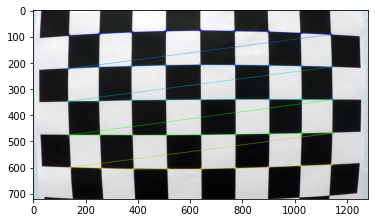

In [ ]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 5#TODO: enter the number of inside corners in y

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)


# Make a list of calibration images
# img = mpimg.imread('resources/camera_cal/calibration1.jpg')
images = glob.glob('./camera_cal/*.jpg')

for idx, fname in enumerate(images):
  # Read in an image
  img = cv2.imread(fname)

  # Convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Find the chessboard corners
  ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

  # If found, draw corners
  if ret == True:
      imgpoints.append(corners)
      objpoints.append(objp)

      # Draw and display the corners
      cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
      plt.imshow(img)

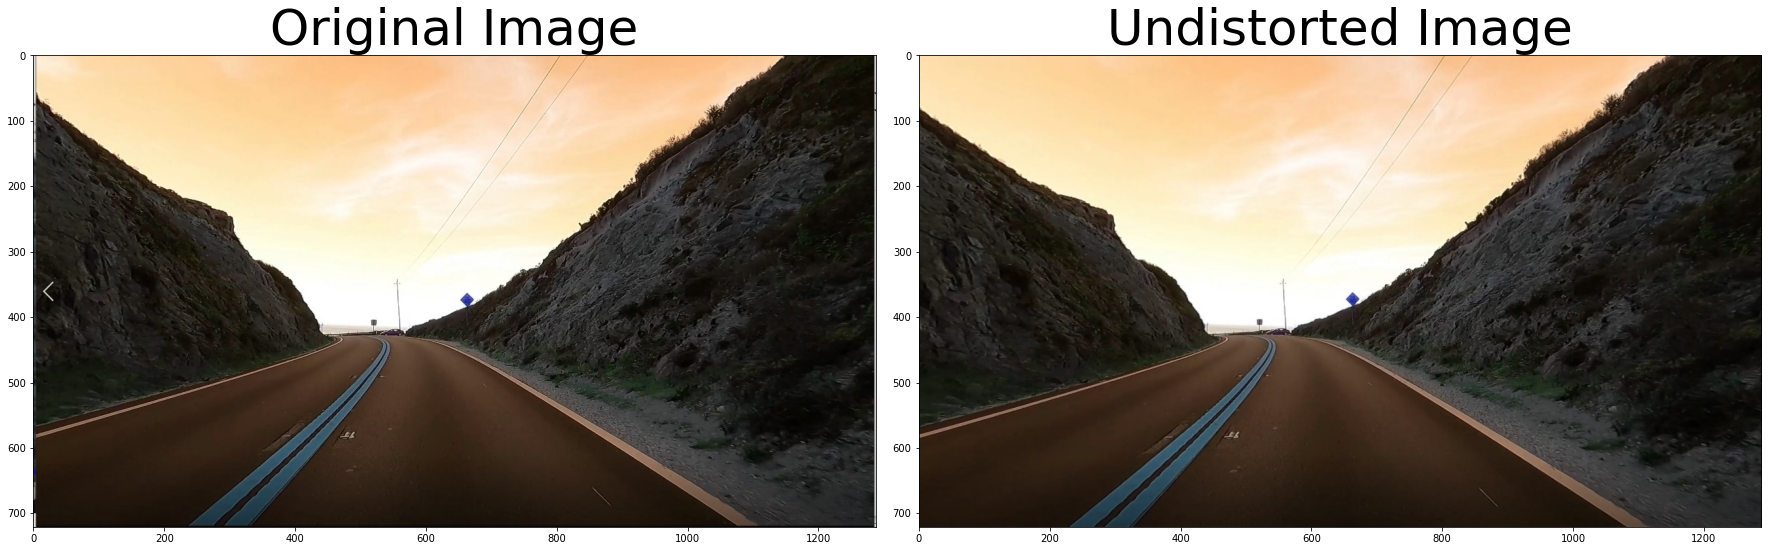

In [ ]:
def cal_undistort(img, objpoints, imgpoints):
  # Use cv2.calibrateCamera and cv2.undistort()
  gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
  undist = cv2.undistort(img, mtx, dist, None, mtx)
  return undist, mtx, dist

# Get test image
img = cv2.imread('image1.jpg')

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

In [ ]:
img = cv2.imread('image1.jpg')

In [ ]:
def plot_images(original, modified, title):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified, cmap='gray')
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def undistort(img):
  #Load pickle
  dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
  mtx = dist_pickle["mtx"]
  dist = dist_pickle["dist"]

  # Undistort sample image
  undistorted = cv2.undistort(img, mtx, dist, None, mtx)
  return undistorted

# undistort it
undistorted = undistort(img)

# printing out some stats and plotting
plot_images(img, undistorted, 'Undistorted Image')

<ipython-input-79-8893634c05b3>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)


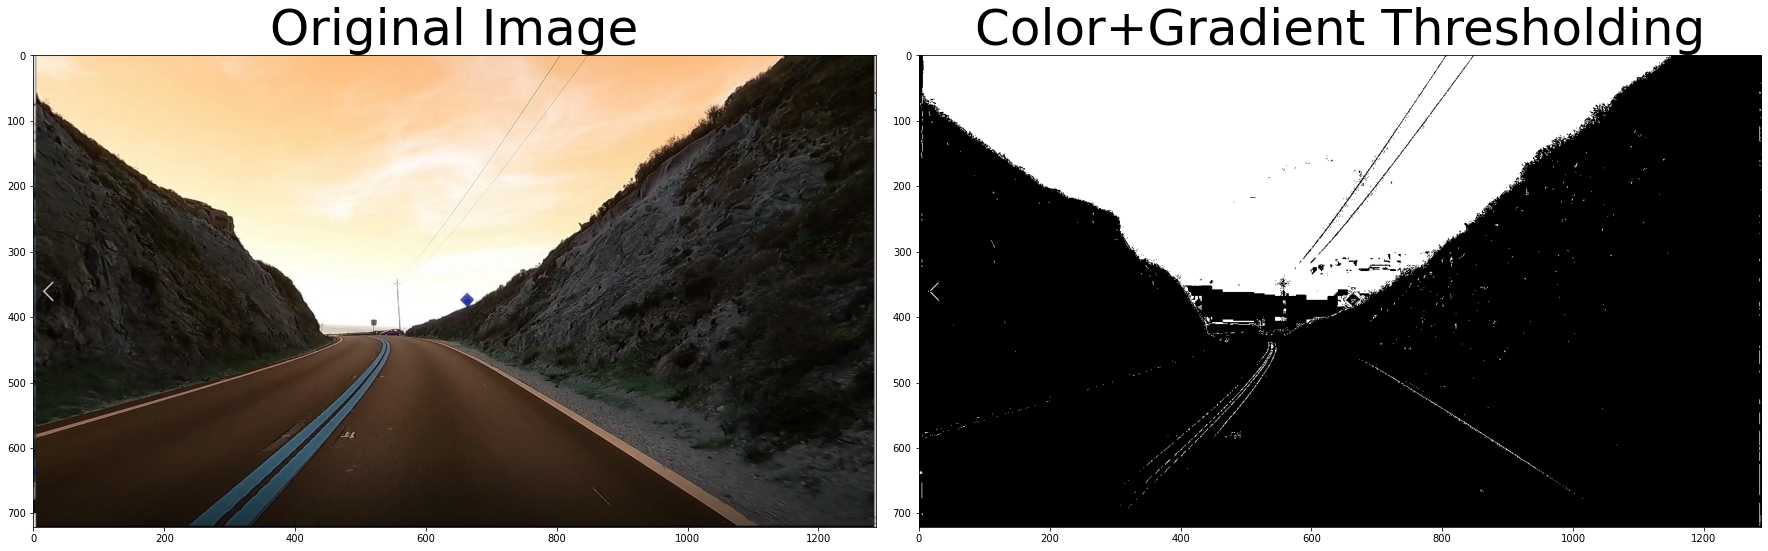

In [ ]:
# Edit this function to create your own pipeline.
def color_gradient_thresh(img, s_thresh=(170, 255), l_thresh=(30, 255), sx_thresh=(65, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient and color
    color_gradient_binary = np.zeros_like(s_channel)
    color_gradient_binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) & ((l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])) | ((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    return color_gradient_binary
    
result = color_gradient_thresh(img)

# Plot the result
plot_images(img, result, 'Color+Gradient Thresholding')

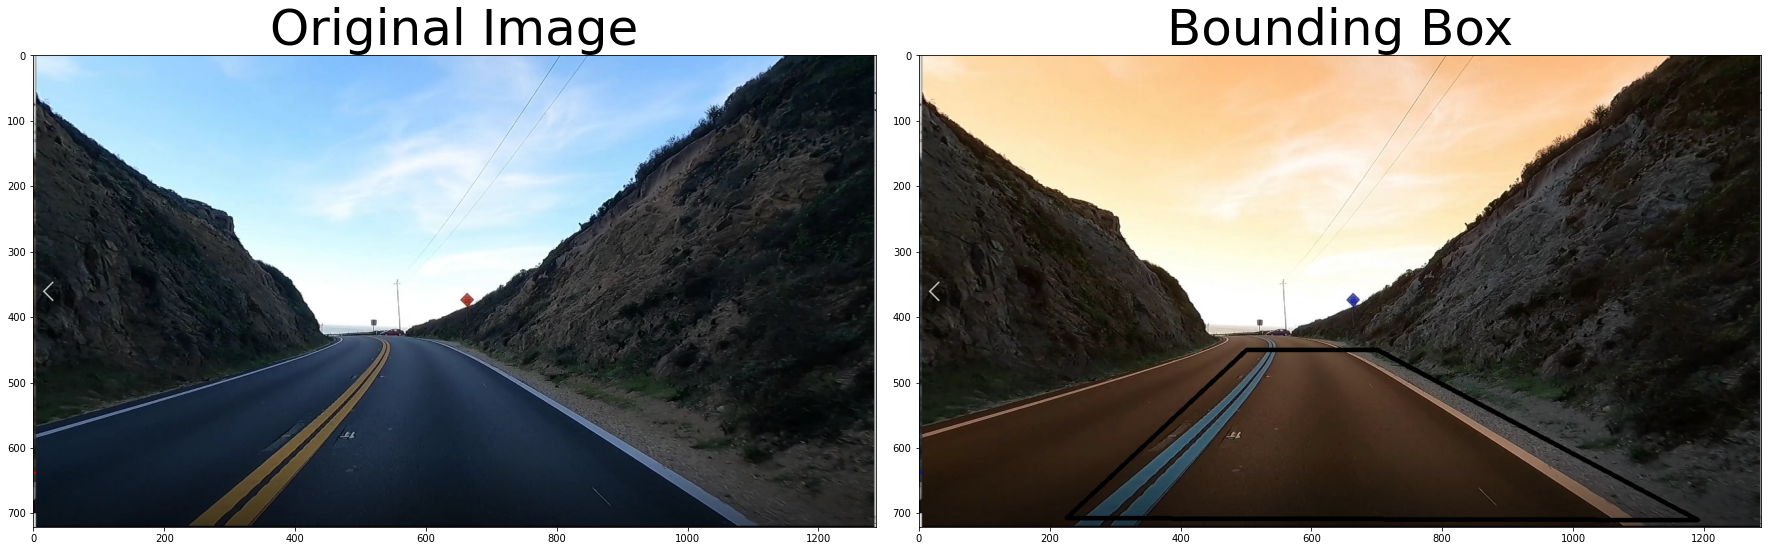

In [ ]:
test_img = cv2.imread('image1.jpg')
points = [(500,450), (700,450), (1190,710),(225,707)] #左上右上右下左下
cv2.line(test_img, points[0], points[1], 0, 5)
cv2.line(test_img, points[1], points[2], 0, 5)
cv2.line(test_img, points[2], points[3], 0, 5)
cv2.line(test_img, points[3], points[0], 0, 5)
plot_images(mpimg.imread('image1.jpg'), test_img, "Bounding Box")

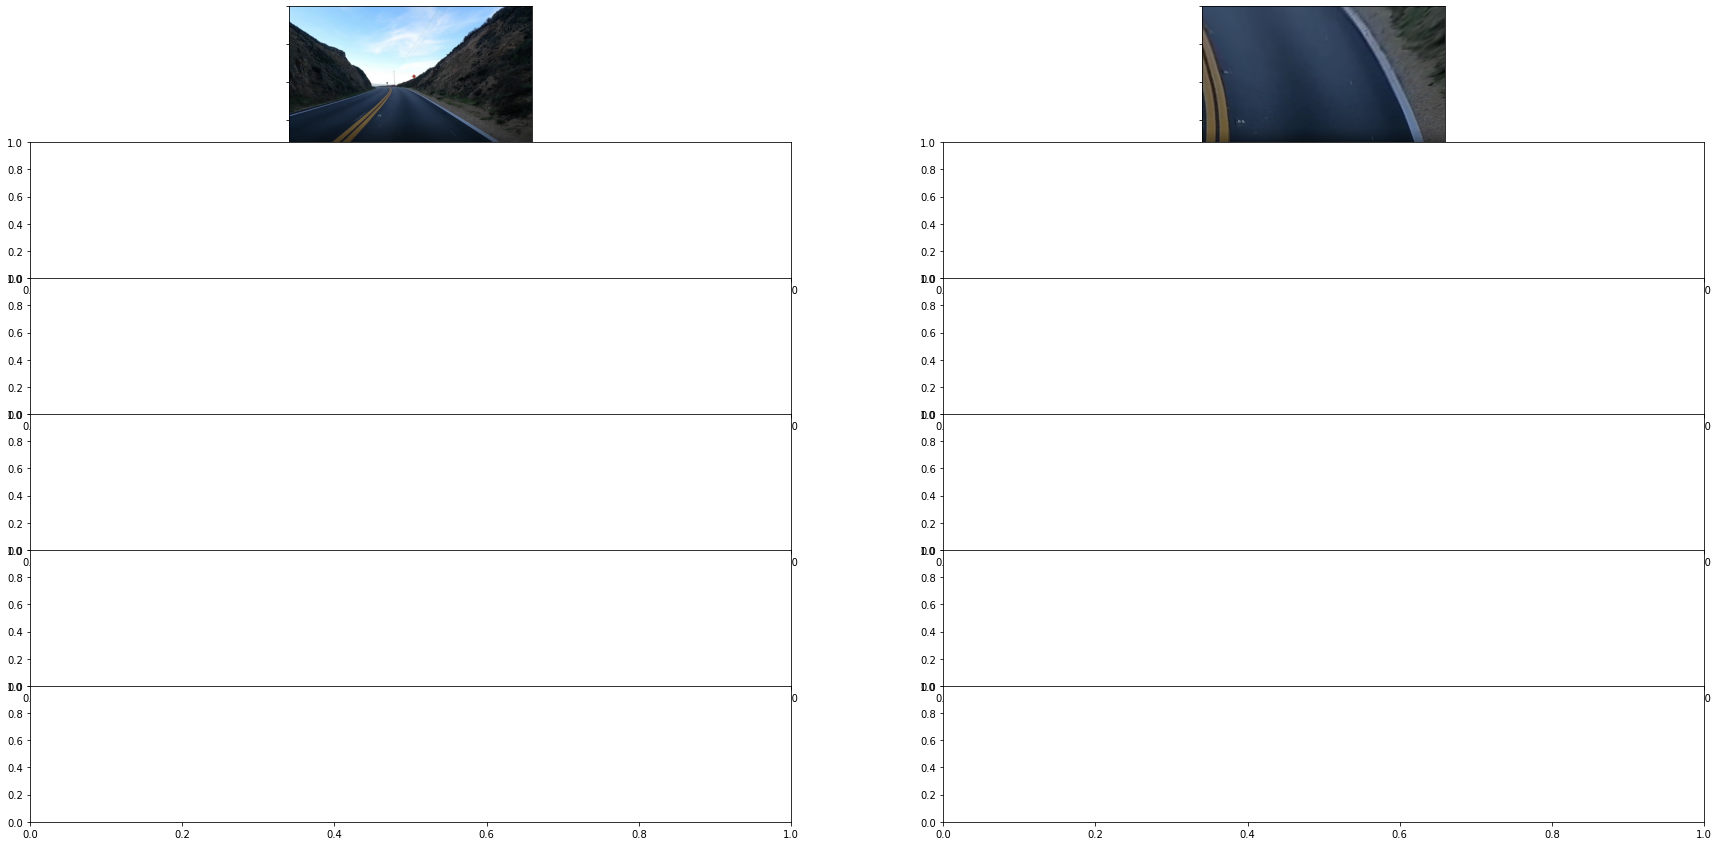

In [ ]:
def perspective_transform(img, mtx, dist, isColor=True):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if(isColor):
        # Convert undistorted image to grayscale
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    else:
        gray = undist

    xoffset = 0 # offset for dst points
    yoffset = 0
    img_size = (undist.shape[1], undist.shape[0])

    src = np.float32([(550,450), (725,450), (1190,710),(225,707)]) #####################
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                 [img_size[0]-xoffset, img_size[1]-yoffset], 
                                 [xoffset, img_size[1]-yoffset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

               
#Load pickle
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
                         
# Run the function

f, axarr = plt.subplots(6, 2, figsize=(30, 15))

cur_img = mpimg.imread('image1.jpg')
cur_img = undistort(cur_img)
transformed, M = perspective_transform(cur_img, mtx, dist)
axarr[0,0].imshow(cur_img)
axarr[0,1].imshow(transformed, cmap='gray')
plt.setp(axarr[0,0].get_yticklabels(), visible=False)
plt.setp(axarr[0,0].get_xticklabels(), visible=False)
plt.setp(axarr[0,1].get_yticklabels(), visible=False)
plt.setp(axarr[0,1].get_xticklabels(), visible=False)

f.subplots_adjust(hspace=0)
f.show()

# **鳥瞰轉換後**

<ipython-input-79-8893634c05b3>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)


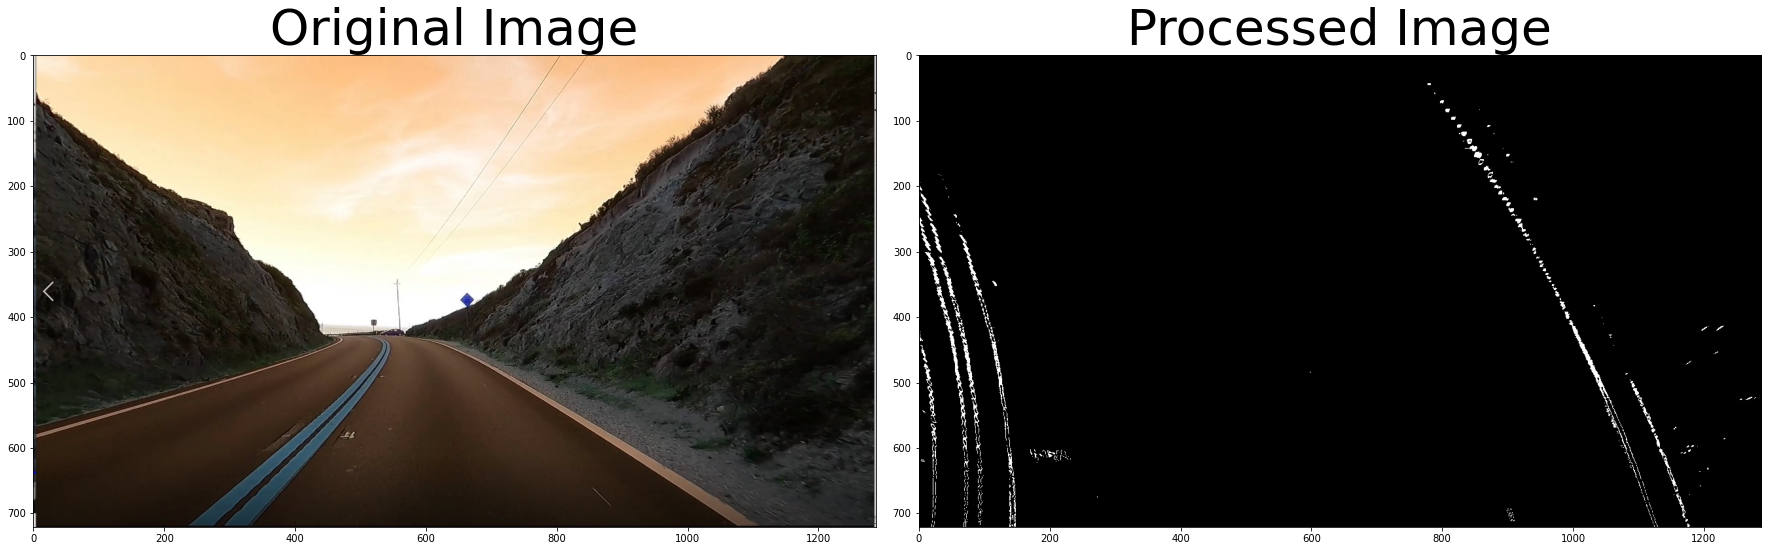

In [ ]:
from scipy.signal import argrelextrema



def process_image(img):
    # undistort it
    #img = undistort(img)
    
    # Apply thresholded gradient
    img = color_gradient_thresh(img)  #鳥瞰轉換完跑這個可以得到邊緣偵測的圖喔
    
    #Apply perspective transform
    #img, M = perspective_transform(img, mtx, dist, isColor=False)
    return img
                                
# Run the function
#img = cv2.imread('image0.jpg')
processed_img= process_image(transformed)
    
# Plot the result

plot_images(img, processed_img, 'Processed Image')

Left fit:  [ 11.99604743  21.33032185  29.60022586  36.80575946  42.94692264
  48.02371542  52.03613778  54.98418972  56.86787126  57.68718238
  57.44212309  56.13269339  53.75889328  50.32072276  45.81818182
  40.25127047  33.61998871  25.92433653  17.16431395   7.33992095
  -3.54884246 -15.50197628]
Right rit:  [1123.08399209 1116.55350085 1109.42800678 1101.70750988 1093.39201016
 1084.48150762 1074.97600226 1064.87549407 1054.17998306 1042.88946923
 1031.00395257 1018.52343309 1005.44791078  991.77738566  977.51185771
  962.65132693  947.19579334  931.14525692  914.49971767  897.25917561
  879.42363072  860.993083  ]
Left curvature:  193.59398978014002
Right curvature:  345.53031292614537


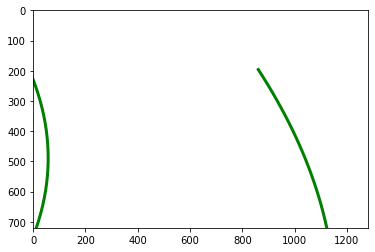

In [ ]:


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def getCurvatureForLanes(processed_img, prev_left_fitx, prev_right_fitx, prev_left_peak, prev_right_peak):
  yvals = []
  leftx = []
  rightx = []
  imageHeight = processed_img.shape[0]
  imageWidth = processed_img.shape[1]
  bufferForDecidingByDistanceFromMid = 10

  left_histogram = np.sum(processed_img[int(imageHeight/4):,:int(imageWidth/2)], axis=0)   
  right_histogram = np.sum(processed_img[int(imageHeight/4):,int(imageWidth/2):], axis=0)

  # get local maxima
  starting_left_peak = np.argmax(left_histogram)
  leftx.append(starting_left_peak)
  
  starting_right_peak = np.argmax(right_histogram)
  rightx.append(starting_right_peak + imageWidth/2)

  curH = imageHeight
  yvals.append(curH)
  increment = 25
  columnWidth = 150
  leftI = 0
  rightI = 0
  while (curH - increment >= imageHeight/4):
      curH =  curH - increment
      leftCenter = leftx[leftI]
      leftI += 1
      rightCenter = rightx[rightI]
      rightI += 1

      # calculate left and right index of each column
      leftColumnL = max((leftCenter - columnWidth/2), 0)
      rightColumnL = min((leftCenter + columnWidth/2), imageWidth)

      leftColumnR = max((rightCenter - columnWidth/2), 0)
      rightColumnR = min((rightCenter + columnWidth/2), imageWidth)

      # imageHeight/2 - (imageHeight - curH)
      lt1,lt2,lt3,lt4=int(curH-increment),int(curH),int(leftColumnL),int(rightColumnL)
      rt1,rt2,rt3,rt4=int(curH-increment),int(curH),int(leftColumnR),int(rightColumnR)
      leftHistogram = np.sum(processed_img[lt1:lt2,lt3:lt4], axis=0)
      rightHistogram = np.sum(processed_img[rt1:rt2,rt3:rt4], axis=0)

      left_peak = np.argmax(leftHistogram)
      right_peak = np.argmax(rightHistogram)
      if(left_peak):
          leftx.append(left_peak+leftColumnL)
      else:
          leftx.append(leftx[leftI-1])

      if(right_peak):
          rightx.append(right_peak+leftColumnR)
      else:
          rightx.append(rightx[rightI-1])
      yvals.append(curH)

  yvals = np.array(yvals)
  rightx = np.array(rightx)
  leftx = np.array(leftx)
  
  # Determine the fit in real space
  left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
  right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
  
  # Define y-value where we want radius of curvature
  y_eval = np.max(yvals)
  left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*left_fit_cr[0])
  right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) \
                                  /np.absolute(2*right_fit_cr[0])

  # Fit a second order polynomial to each lane line
  left_fit = np.polyfit(yvals, leftx, 2)
  left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
  right_fit = np.polyfit(yvals, rightx, 2)
  right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
      
  return left_curverad, right_curverad, left_fitx, right_fitx, yvals, starting_right_peak, starting_left_peak

left_curverad, right_curverad, left_fitx, right_fitx, yvals, right_peak, left_peak = getCurvatureForLanes(processed_img, [], [], [], [])

# Plot the two lines
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

print("Left fit: ", left_fitx)
print("Right rit: ", right_fitx)
print("Left curvature: ", left_curverad)
print("Right curvature: ", right_curverad)

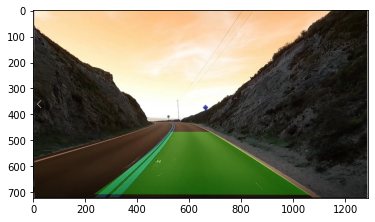

In [ ]:
from numpy.linalg import inv

def drawLane(warped, M, undist, left_fitx, right_fitx, yvals):
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(warped).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
  
  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  Minv = inv(M)
  newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
  # Combine the result with the original image
  return cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

result = drawLane(processed_img, M, img, left_fitx, right_fitx, yvals)
plt.imshow(result)